# Библиотеки и функции

In [1]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Библиотеки
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import datetime
from sklearn.metrics import r2_score
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as MAE
import typing as tp
import matplotlib.ticker as ticker

from prophet import Prophet

In [3]:
# Функции
def AFO_Fourier(series, harm_num):
  """
  Функция расчета коэффициентов Фурье методом АФО. 
  :series: pd.Series — временной ряд с индексами 0,1,2,...
  :harm_num: int — номер выделяемой гармоники
  :return: список коэффициентов [a_0, a, b]
  ([свободный коэффициент, к-т при косинусе, к-т при синусе])
  """
  period_len = len(series)
  if harm_num > period_len // 2:
    print('Номер выделяемой гармоники не может превышать N/2, где N - число замеров ряда')
    return [0] * 3
  const_term = np.mean(series)
  param_s = mt.ceil((period_len // 2 + 1) / harm_num)
  AFO_order = harm_num * (param_s - 1)
  slice_series = series[
                        np.ceil(period_len / AFO_order * np.arange(AFO_order))
  ]
  slice_series.index = np.arange(AFO_order)
  phase = 2 * mt.pi * np.arange(AFO_order) / AFO_order
  amplitude = - 2 / (AFO_order) * (
      np.cos(mt.pi * param_s / (param_s + 1)) - np.cos(phase * harm_num)
      )
  omega = - 2 * np.cos(mt.pi * param_s / (param_s + 1))
  rez_garm = np.zeros(AFO_order)
  for i in range(AFO_order):
    rez_garm[i] = np.sum(amplitude[0:i+1] * slice_series[i::-1]) + np.sum(amplitude[i+1:AFO_order] * slice_series[AFO_order-1:i:-1])
  rez_garm -= const_term * omega
  a = rez_garm[0]
  point_koef_b = mt.pi / (2 * harm_num)
  delta_points = phase - point_koef_b
  for i in range((AFO_order + 1) // 2):
    if delta_points[i] * delta_points[i+1] <= 0:
      delta_phase = phase[i+1] - phase[i]
      l_wght = (phase[i+1] - point_koef_b) / (delta_phase)
      b = l_wght * rez_garm[i] + (1 - l_wght) * rez_garm[i+1]
      break
  return list([const_term,a,b])

def coeff_lin(x_data, y_data):
  """
  Функция расчета коэффициентов линейной аппроксимации методом МНК. 
  :x_data: массив значений x
  :y_data: массив значений y
  :return: список коэффициентов [a, b] для уравнения регресии y = ax + b
  """
  x_sum = np.sum(x_data)
  y_sum = np.sum(y_data)
  xy_sum = np.sum(x_data * y_data)
  x_sq_sum = np.sum(np.power(x_data,2))
  count_koeff = len(x_data)
  koef_lin_a = (
      (count_koeff * xy_sum - x_sum * y_sum) /
      (count_koeff * x_sq_sum - x_sum ** 2)
    )
  koef_lin_b = (y_sum - koef_lin_a * x_sum) / count_koeff
  return list([koef_lin_a, koef_lin_b])

def lin_interp(delta_x, l_point, r_point):
  """
  Функция линейно заполняет 
  (delta_x - 1) точек между значениями l_point и r_point
  :delta_x: int — разность между номерами точек l_point и r_point
  :l_point: первая точка для интерполяции (левая граница)
  :r_point: вторая точка для интерполяции (правая граница)
  :return: список из (delta_x - 1) значений
  """
  return list(np.arange(1,delta_x) * (r_point - l_point) / delta_x + l_point)

def mape(y_true, y_pred):
  """
  Вычисление значения MAPE
  :y_true: массив реальных значений
  :y_pred: массив прогнозных значений
  :return: float — число от 0 до 1
  """
  return np.mean(abs(y_true - y_pred) / abs(y_true))

def sort_data(data_name, cols):
  """
  Функция экспортирует данные, задает название столбцов,
  сортирует данные по дате, обновляет индексы, считает размер данных.
  :data_name: string — название данных (имя файла без расширения)
  :cols: список целых чисел — номеров колонок для экспорта данных
  :return: period_len — размер данных,
  sorted_data — отсортированные данные
  """
  filename = data_name + '.xlsx'
  data = pd.read_excel(filename, usecols = cols)
  data.rename(
      columns={data.columns[0]: 'date', data.columns[1]: 'val'},
      inplace=True
      )
  sorted_data = data.sort_values(by='date') # Сортировка по дате
  period_len = len(sorted_data.index) # Размер данных
  sorted_data.index = np.arange(period_len) # Обновляем индексы
  return period_len, sorted_data

def fill_gaps(data, period_len):
  """
  Заполняет пропуски в данных, если есть разрывы между датами
  :data: pd.DataFrame — данные с датами
  :period_len: int — размер данных
  :return: full_data — данные с заполненными пропусками
  """
  time_range = (data.date[period_len - 1] - data.date[0]).days + 1
  if time_range > period_len:
    full_data = pd.DataFrame(
        {'date': [data.date[0] + datetime.timedelta(days=x)
        for x in range(time_range)], 'val': None}
        )
    full_data.val[0] = data.val[0]
    day = 1
    for i in range(1, period_len):
      time_rng = (data.date[i] - data.date[i - 1]).days
      if time_rng > 1:
        full_data.val[day: day + time_rng - 1] = (
            lin_interp(time_rng, data.val[i-1], data.val[i])
        )
        full_data.val[day + time_rng - 1] = data.val[i] 
        day += time_rng
      else:
        full_data.val[day] = data.val[i]
        day += 1
  else:
    full_data = data
  time_range = len(full_data.index)
  return time_range, full_data


def plot_data(
    time1, data1, label1 = '',
    time2 = [], data2 = [], label2 = '',
    time3 = [], data3  = [], label3  = '',
    x_label = 'Дата',
    y_label = 'Значение ряда',
    title = [],
    count = 1
    ):
  """
  Функция строит график (до трех кривых).
  :time1, data1, label1: параметры первой кривой
  :time2, data2, label2: параметры второй кривой
  :time3, data3, label3: параметры третьей кривой
  :x_label, y_label: подписи осей
  :title: заголовок графика
  :count: количество кривых на графике
  """
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 15
  fig_size[1] = 7
  plt.rcParams['font.size'] = '18'
  plt.rcParams["figure.figsize"] = fig_size

  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(
      time1,
      data1,
      label = label1,
      color = 'darkgreen',
      linewidth = 3
      )
  if count > 1:
    plt.plot(
        time2,
        data2,
        label = label2,
        color = 'maroon',
        linewidth = 3
        )
  if count == 3:
    plt.plot(
        time3,
        data3,
        label = label3,
        color = 'midnightblue',
        linewidth = 3
        )
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  if count > 1:
    plt.legend()
  plt.grid(True)
  plt.show()

def get_ewma_forecast(
    time_series: tp.Iterable[float], 
    horizon: int,
    window_width: int = 10,
    ewma_alpha: float = 0.1
    ) -> tp.Iterable[float]:
 
    assert horizon > 0
    assert window_width > 0
    assert 0 <= ewma_alpha <= 1
 
    window = list(time_series[-window_width:])
    forecast = []
 
    for _ in range(horizon):
        ewma_prediction = (
            pd.Series(window)
            .ewm(adjust=False, alpha=ewma_alpha)
            .mean()
            .iloc[-1]
        )
        forecast.append(ewma_prediction)
        window = window[1:] + [ewma_prediction]

    return forecast

def plot_data_pred(
    time_past, time_pred, past, true,
    pred1, pred2, pred3, pred4,
    label1, label2, label3, label4,
    title = '' 
    ):
  """
  Функция строит график шести кривых.
  Первая из них - известные значения из прошлого,
  вторая - реальные значения,
  остальные четыре - прогнозы,
  :time_past: интервал времени известных значений
  :time_pred: интервал времени для прогнозов
  :past: известные значения из прошлого
  :true: реальные значения
  :pred1, pred2, pred3, pred4: прогнозы
  :label1, label2, label3, label4: названия прогнозов
  :title: заголовок графика
  """
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 15
  fig_size[1] = 7
  plt.rcParams['font.size'] = '16'
  plt.rcParams["figure.figsize"] = fig_size
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(
      time_past,
      past,
      label = 'Известные значения',
      color = 'darkgreen',
      linewidth = 2
      )
  plt.plot(
      time_pred,
      true,  "--",
      label = 'Реальные значения',
      color = 'darkgreen',
      linewidth = 2,
      )
  plt.plot(
      time_pred,
      pred1,
      label = label1,
      linewidth = 2,
      color = 'black',
      )
  plt.plot(
      time_pred,
      pred2,
      label = label2,
      linewidth = 2,
      color = 'blue',
      )
  plt.plot(
      time_pred,
      pred3,
      label = label3,
      linewidth = 2,
      color = 'orange',
      )
  plt.plot(
      time_pred,
      pred4,
      label = label4,
      linewidth = 2,
      color = 'maroon',
      )
  ax.set_title(title)
  ax.set_xlabel('Дата')
  ax.set_ylabel('Значение')
  plt.legend()
  plt.grid(True)
  plt.show()

# 0. Импорт и предобработка данных

- Данные представляют собой несортированные по дате замеры временного ряда. Первый столбец - дата замера, второй столбец - значение. Очень часто при импорте данных из архива даты по умолчанию отсортированы в обратном порядке, поэтому создаем DataFrame и сортируем его по дате (по возрастанию).

- Из списка можно выбрать название файла с данными.

- Необходимо заполнить пропуски в данных, если они имеются (чаще всего данные о курсах валют, стоимости ценных бумагах и т.п. обновляются только по рабочим дням). Заполнение проводим методом линейной интегрполяции по двум значниям на границах интервала с пропуском.

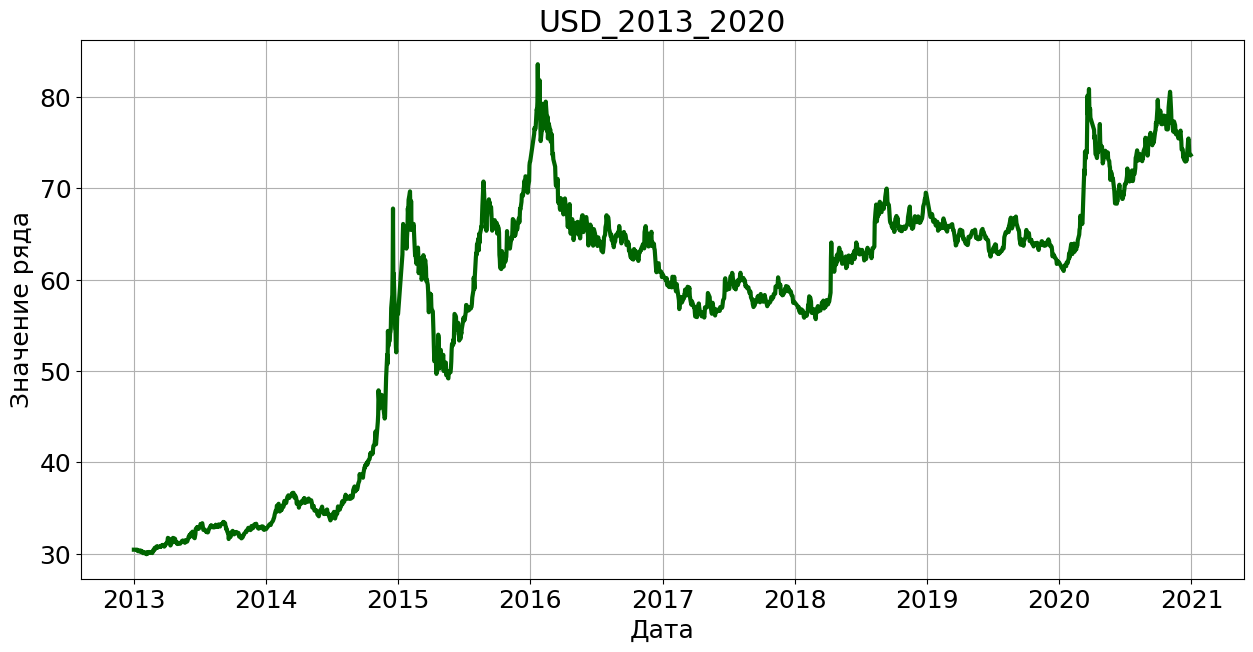

In [4]:
# Import data
# BLRS_2017_2021
# BRENT_2013_2020
# BRENT_2017_2021
# BRENT_2020_2021
# BrPound_2013_2020
# BrPound_2019
# Covid_RUS
# EUR_2013_2020
# EUR_2017_2021
# EUR_2020
# GOLD_2013
# GOLD_2013_2020
# Light_2013_2020
# USD_2013_2020
# USD_2017_2021
# USD_2020

data_name = 'USD_2013_2020' # Имя файла с данными
cols = [1, 2] # Столбцы с необходимыми данными
period_len, sorted_data = sort_data(data_name, cols) # Сортировка по дате
time_range, full_data = fill_gaps(sorted_data, period_len) # Заполняем пропуски
plot_data(
    time1 = full_data.date,
    data1 = full_data.val, 
    title = data_name
    )

# 1. Аппроксимация временого ряда с помощью АФО #

Вычисляем линейный тренд и вычитаем его из ряда.

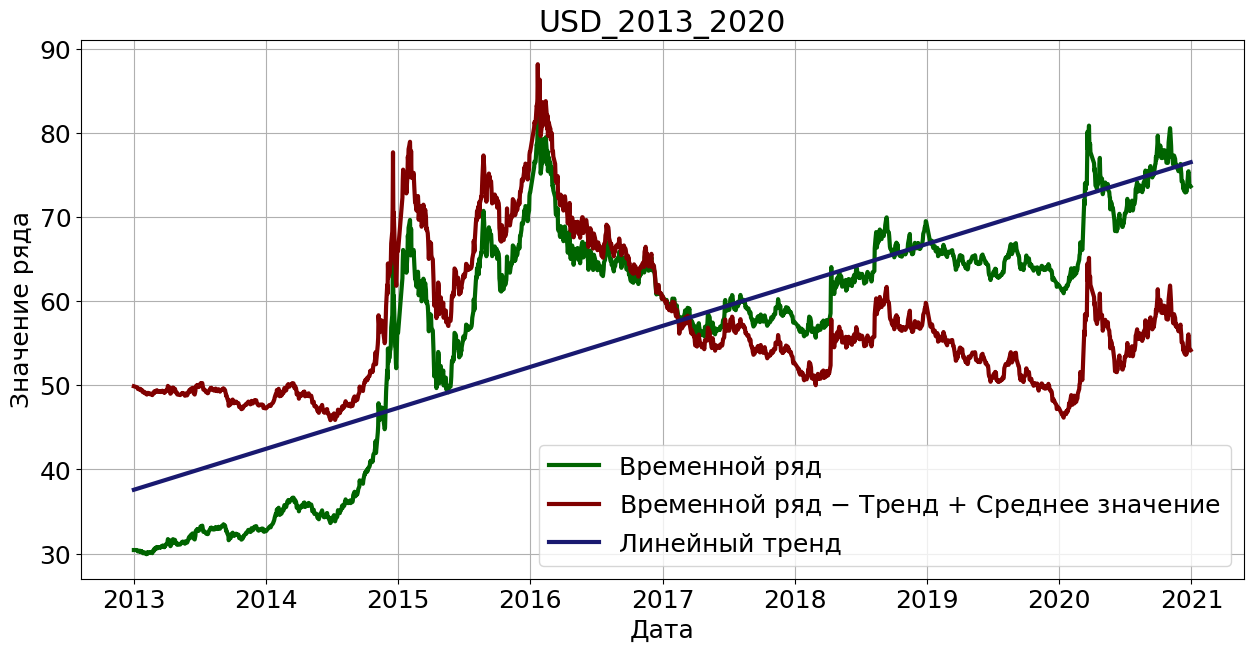

In [5]:
[koef_lin_a, koef_lin_b] = coeff_lin(full_data.index, full_data.val)
trend = koef_lin_a * full_data.index + koef_lin_b
plot_data(
    time1 = full_data.date,
    data1 = full_data.val,
    label1 = 'Временной ряд',
    time2 = full_data.date,
    data2 = full_data.val - trend + np.mean(full_data.val),
    label2 = 'Временной ряд $-$ Тренд + Среднее значение',
    time3 = full_data.date,
    data3 = trend,
    label3 = 'Линейный тренд',
    title = data_name,
    count = 3
    )


## 1.1 Выделение из ряда заданной частоты #

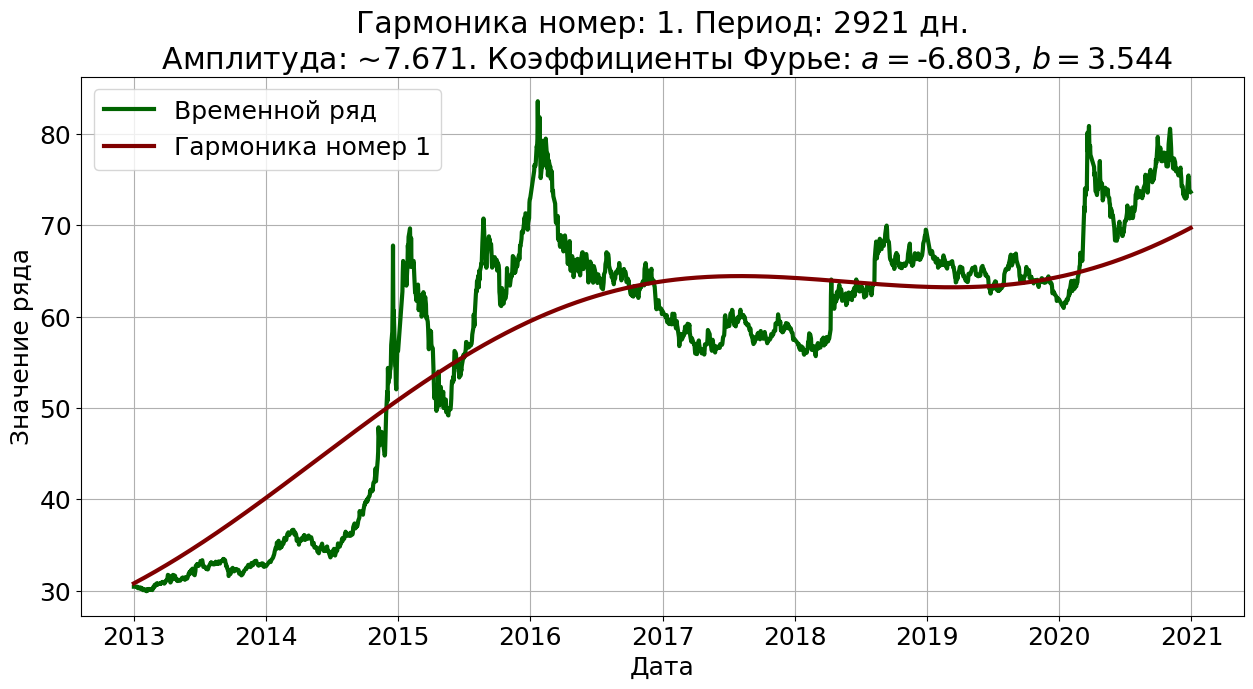

In [6]:
FREQ = 1 # Номер выделяемой гармоники

series = full_data.val - trend
phase =  2 * mt.pi * np.arange(time_range) / time_range
koef = AFO_Fourier(series, FREQ)
garm = koef[0] + koef[1] * np.cos(FREQ * phase) + koef[2] * np.sin(FREQ * phase)
amplitude = float('{:.3f}'.format(mt.sqrt(koef[1] ** 2 + koef[2] ** 2)))
period =  int(time_range // FREQ)

title = (
    'Гармоника номер: ' + str(FREQ) + '. Период: ' + str(period) +
    ' дн.\n Амплитуда: ~' + str(amplitude) + '. Коэффициенты Фурье: $a = $' +
    str(float('{:.3f}'.format(koef[1]))) + ', $b = $'  +
    str(float('{:.3f}'.format(koef[2])))
    )
plot_data(
    time1 = full_data.date,
    data1 = full_data.val,
    label1 = 'Временной ряд',
    time2 = full_data.date,
    data2 = garm + trend,
    label2 = 'Гармоника номер ' + str(FREQ),
    title = title,
    count = 2
    )

## 1.2 Аппроксимация суммой из count_garm гармоник #

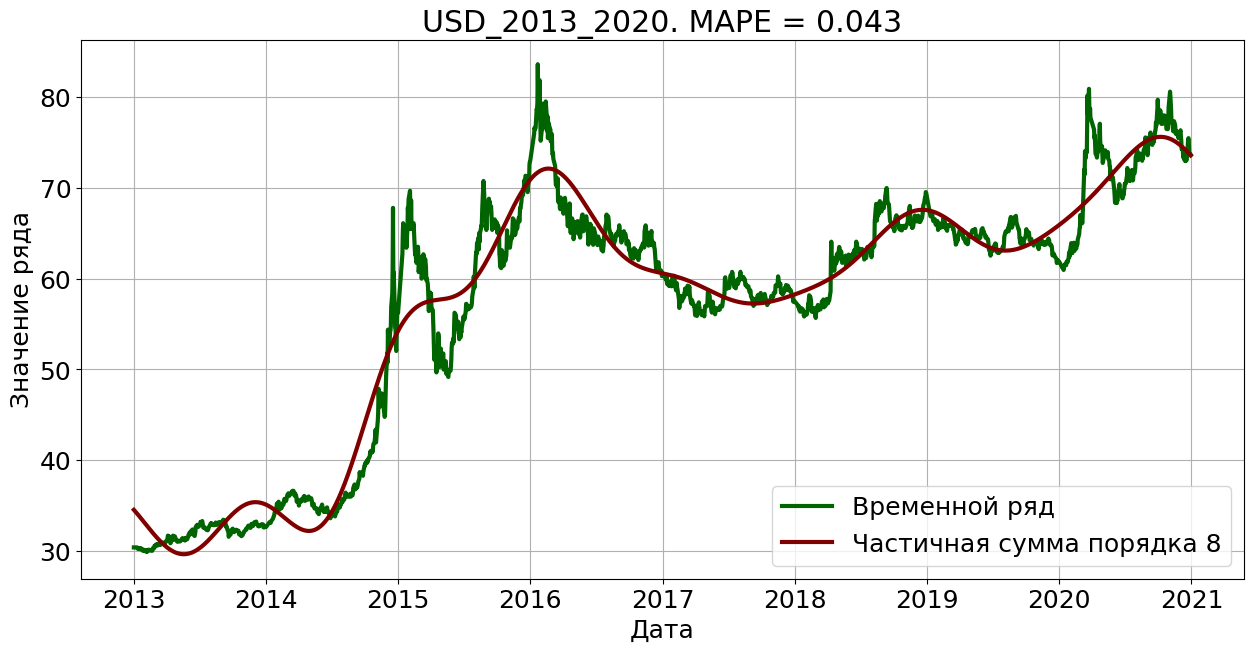

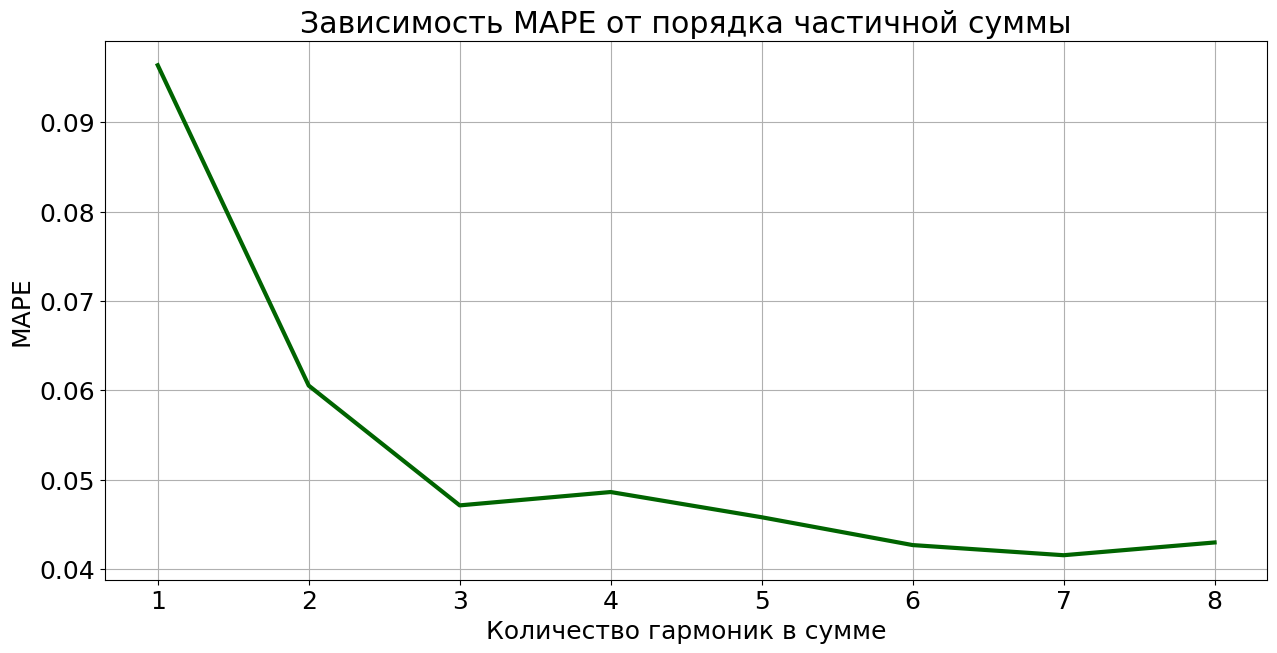

In [7]:
COUNT_GARM = 8

summ = np.zeros(time_range)
series = full_data.val - trend
phase =  2 * mt.pi * np.arange(time_range) / time_range
MAPE = []
for i in range(COUNT_GARM):
  koef = AFO_Fourier(series, i + 1)
  garm = koef[1] * np.cos((i + 1) * phase) + koef[2] * np.sin((i + 1) * phase)
  summ += garm
  MAPE.append(mape(full_data.val, summ + trend + koef[0])) 
summ += koef[0]

title = data_name + '. MAPE = ' + str(float('{:.3f}'.format(MAPE[-1:][0])))
plot_data(
    time1 = full_data.date,
    data1 = full_data.val,
    label1 = 'Временной ряд',
    time2 = full_data.date,
    data2 = summ + trend,
    label2 = 'Частичная сумма порядка ' + str(COUNT_GARM),
    title = title,
    count = 2
    )

title = 'Зависимость MAPE от порядка частичной суммы'
plot_data(
    time1 = np.arange(1,COUNT_GARM + 1),
    data1 = MAPE,
    title = title,
    x_label = 'Количество гармоник в сумме',
    y_label = 'MAPE',
    count = 1,
    )

## 1.3 Построение частичной суммы по заданному значению MAPE #

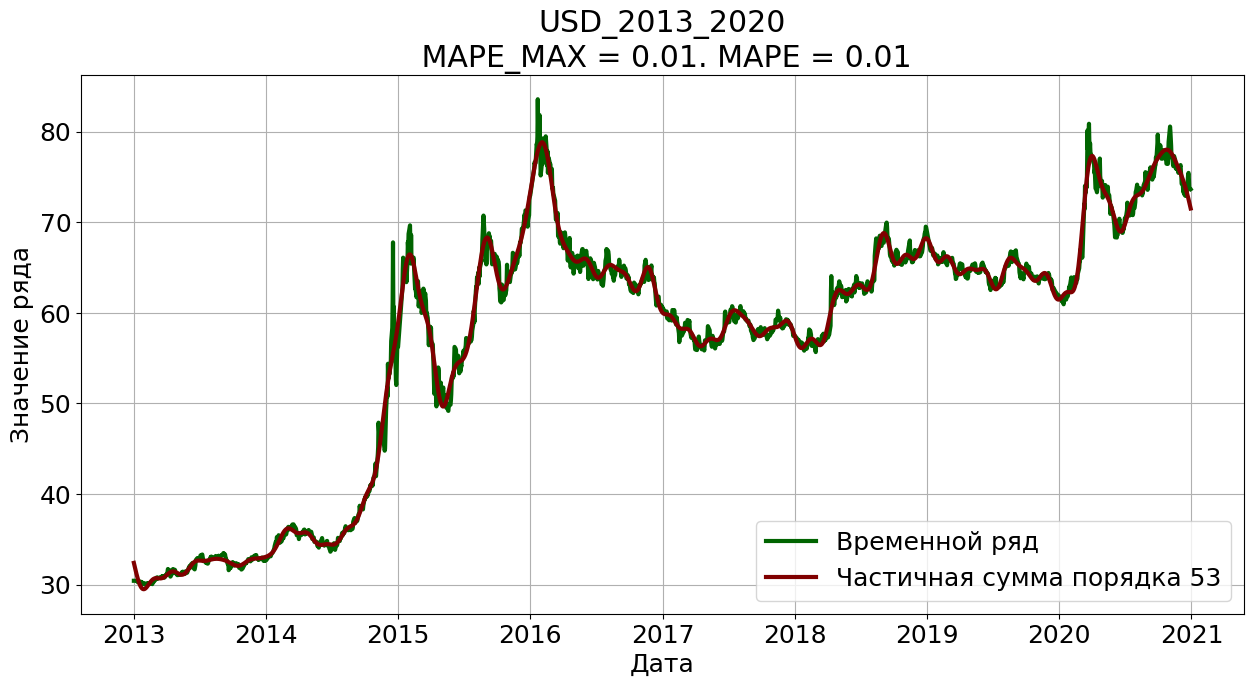

In [8]:
MAPE_MAX = 0.01 # Максимально допустимое значение MAPE
count_garm = time_range // 2
summ = np.zeros(time_range)
series = full_data.val - trend
phase_plot =  2 * mt.pi * np.arange(time_range) / time_range
MAPE = []
if MAPE_MAX <= 0 or MAPE_MAX > 1:
  print('Некорректное значение MAPE_MAX')
else:
  for i in range(count_garm):
    koef = AFO_Fourier(series, i + 1)
    garm = koef[1] * np.cos((i + 1) * phase_plot) + koef[2] * np.sin((i + 1) * phase_plot)
    summ += garm
    MAPE.append(mape(series + trend, summ + trend + koef[0]))
    if MAPE[-1:][0] <= MAPE_MAX:
      count_garm = i + 1
      break

  if MAPE[i] > MAPE_MAX:
    summ = np.zeros(time_range)
    ind_min = np.argmin(MAPE)
    count_garm = ind_min
    for i in range(count_garm):
      koef = AFO_Fourier(series, i + 1)
      garm = koef[1] * np.cos((i + 1) * phase_plot) + koef[2] * np.sin((i + 1) * phase_plot)
      summ += garm
  summ += koef[0]



if MAPE[-1:][0] > MAPE_MAX:
  title = (
      data_name + '\n Не удалось достигнуть MAPE_MAX = ' +
      str (MAPE_MAX) + '.\n ' +'Наилучший результат:  MAPE = ' +
      str(float('{:.3f}'.format(MAPE[ind_min])))
      )
else:
  title = (
      data_name + '\n MAPE_MAX = ' + str(MAPE_MAX) + '. MAPE = ' +
      str(float('{:.3f}'.format(MAPE[-1:][0])))
      )
plot_data(
    time1 = full_data.date,
    data1 = full_data.val,
    label1 = 'Временной ряд',
    time2 = full_data.date,
    data2 = summ + trend,
    label2 = 'Частичная сумма порядка ' + str(count_garm),
    title = title,
    count = 2
    )

# 2. Прогнозирование временного ряда методами регрессионного анализа

## 2.1 STL-разложение

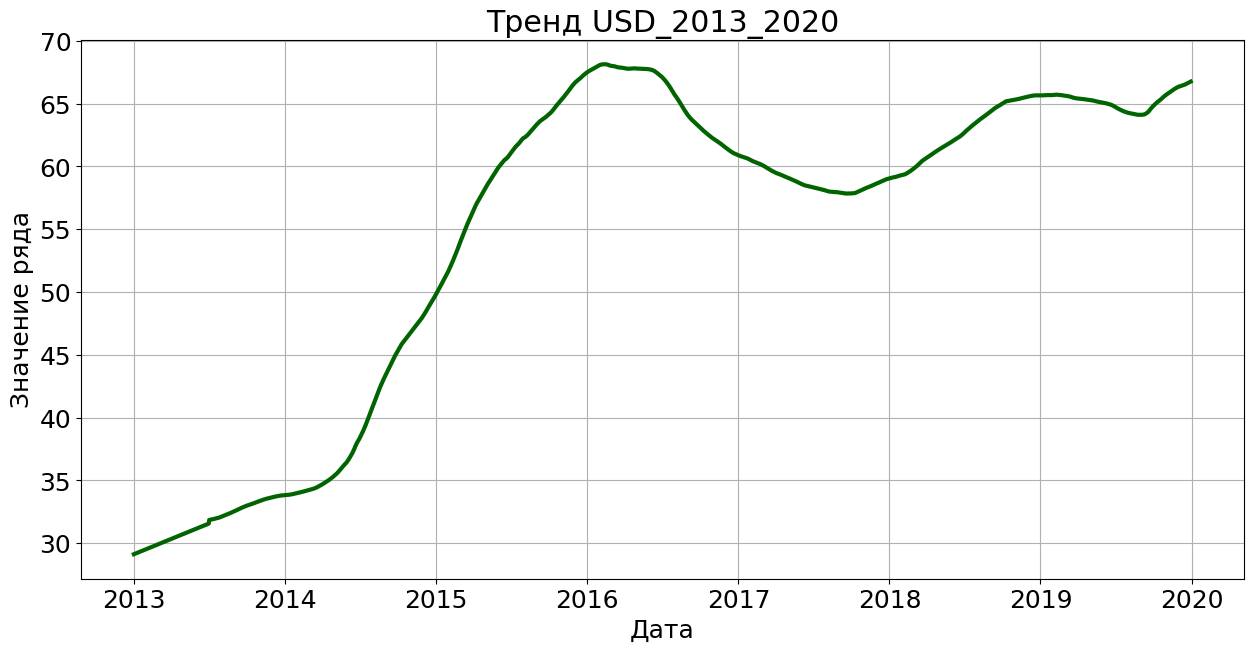

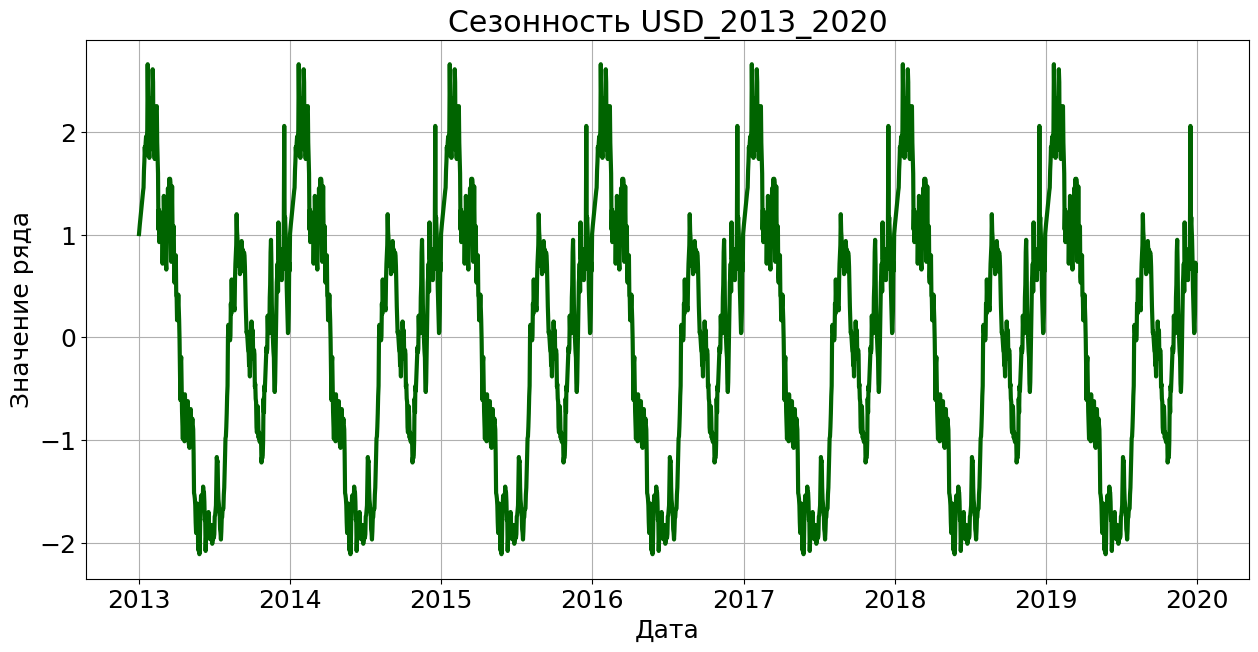

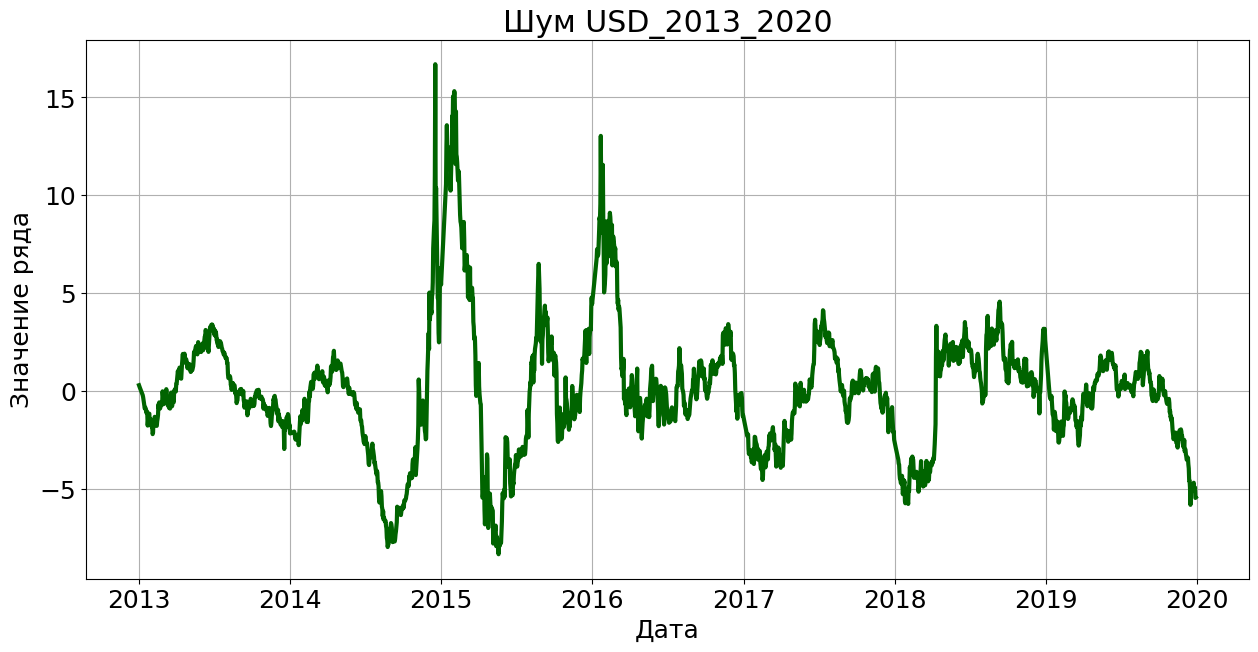

In [12]:
PER_SIZE = 365 # Размер периода
TRAIN_PER = 7 # Количество известных периодов 

series = pd.to_numeric(
    pd.Series(full_data.val.values),
    errors = 'coerce'
    )
stl_decomp = seasonal_decompose(
    series[0: PER_SIZE * (TRAIN_PER + 1)],
    period = PER_SIZE,
    extrapolate_trend = 'freq'
    )

time_past = full_data.date[0 : TRAIN_PER * PER_SIZE]
plot_data(
    time1 = time_past,
    data1 = stl_decomp.trend[0 : TRAIN_PER * PER_SIZE],
    title = 'Тренд '  + data_name,
    count = 1
    )

plot_data(
    time1 = time_past,
    data1 = stl_decomp.seasonal[0 : TRAIN_PER * PER_SIZE],
    title = 'Сезонность '  + data_name,
    count = 1
    )

plot_data(
    time1 = time_past,
    data1 = stl_decomp.resid[0 : TRAIN_PER * PER_SIZE],
    title = 'Шум '  + data_name,
    count = 1
    )

## 2.2 Прогнозирование тренда 

### 2.2.1 Линейная экстраполяция

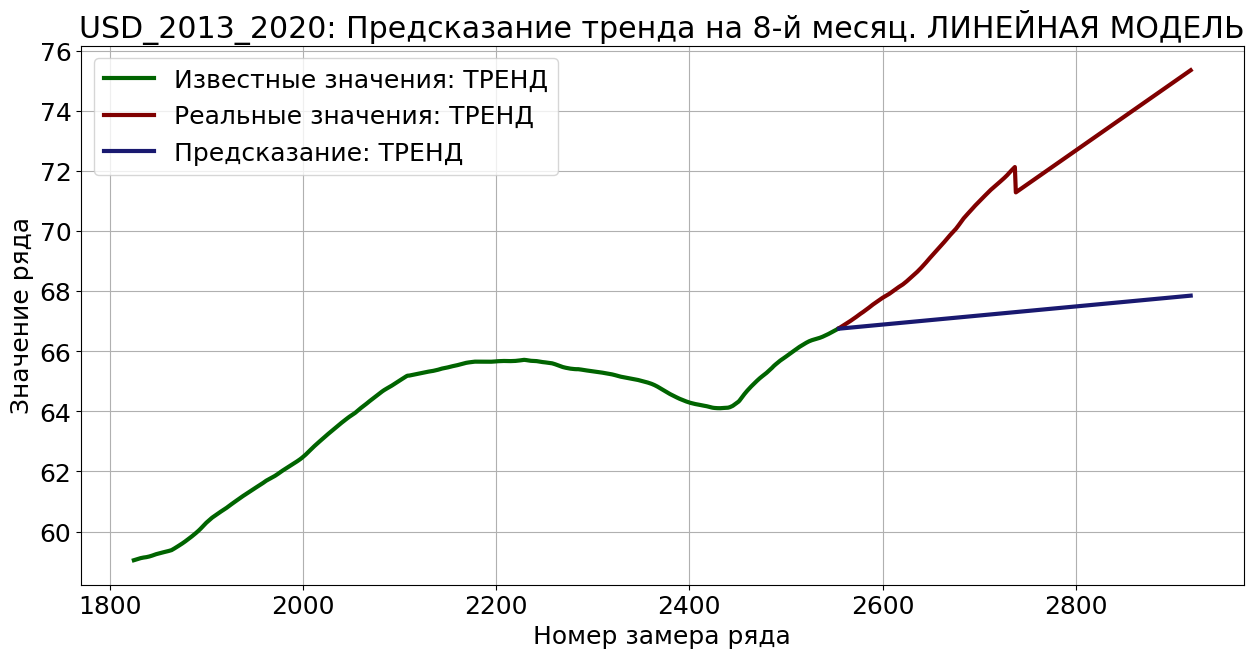

In [13]:
PAST_PER = 1 # Количество периодов, по которым строится прямая

time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)

[koef_lin_a, koef_lin_b] = coeff_lin(
    np.array([(TRAIN_PER - PAST_PER) * PER_SIZE, TRAIN_PER * PER_SIZE - 1]),
    np.array(
        [ stl_decomp.trend[(TRAIN_PER - PAST_PER) * PER_SIZE],
         stl_decomp.trend[TRAIN_PER * PER_SIZE - 1]]
         )
    )
trend_frcst = koef_lin_a * time_pred + koef_lin_b

pred = trend_frcst
true = stl_decomp.trend[time_pred]
past = stl_decomp.trend[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения: ТРЕНД',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения: ТРЕНД',
    time3 = time_pred,
    data3 = pred,
    label3 = 'Предсказание: ТРЕНД',
    title = (
        data_name + ': Предсказание тренда на ' +
        str(TRAIN_PER + 1) + '-й месяц. ЛИНЕЙНАЯ МОДЕЛЬ'
        ),
    x_label = 'Номер замера ряда',
    count = 3
    )

### 2.2.2 Прогнозирование с помощью EWMA

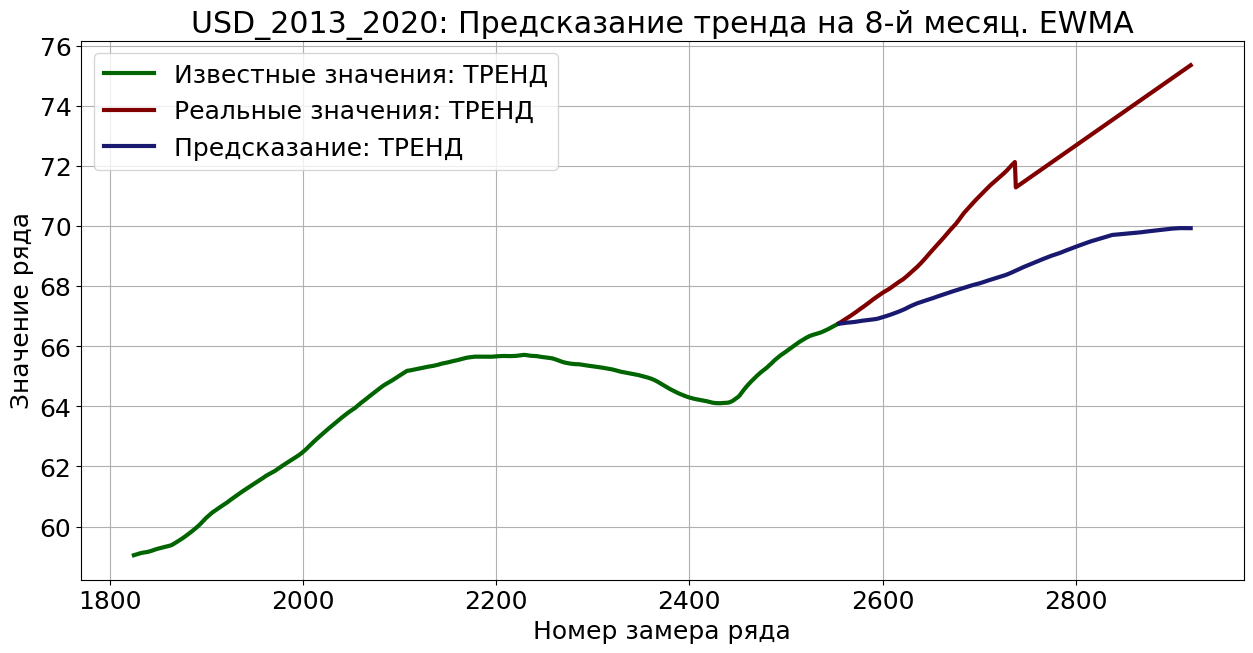

In [14]:
WIN_WID = PER_SIZE * 2 # Окно сглаживания
ALPHA = 0.001 # Параметр сглаживания

time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)

trend_train = stl_decomp.trend[0: TRAIN_PER * PER_SIZE]

ewma_forecast = get_ewma_forecast(
    trend_train, 
    horizon = PER_SIZE, 
    window_width = WIN_WID, 
    ewma_alpha = ALPHA
)
ewma_forecast = pd.Series(ewma_forecast)
ewma_forecast = ewma_forecast - ewma_forecast[0] + trend_train[TRAIN_PER * PER_SIZE - 1] 

pred = ewma_forecast
true = stl_decomp.trend[time_pred]
past = stl_decomp.trend[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения: ТРЕНД',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения: ТРЕНД',
    time3 = time_pred,
    data3 = pred,
    label3 = 'Предсказание: ТРЕНД',
    title = (
        data_name + ': Предсказание тренда на ' +
        str(TRAIN_PER + 1) + '-й месяц. EWMA'
        ),
    x_label = 'Номер замера ряда',
    count = 3
    )

## 2.3 Прогнозирование шума

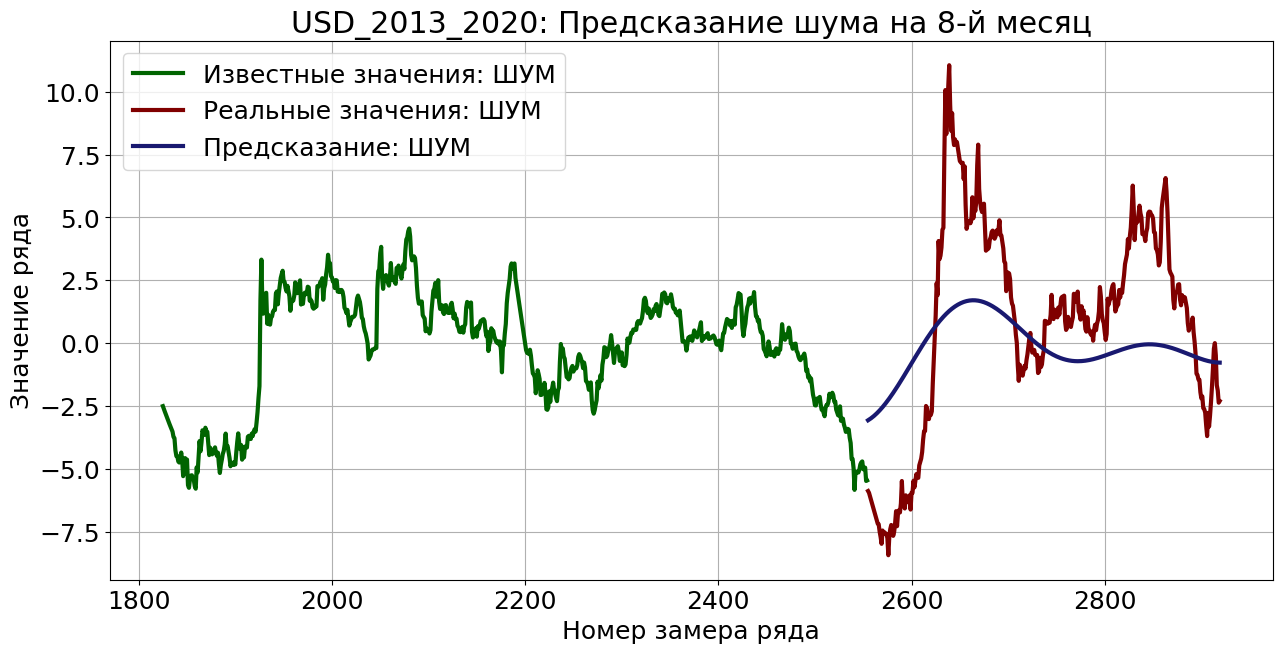

In [15]:
QUANTILE = 0.95

resid = stl_decomp.resid[0: TRAIN_PER * PER_SIZE]
phase =  2 * mt.pi * np.arange(PER_SIZE * TRAIN_PER) / (PER_SIZE * TRAIN_PER)
amplitude = []

for i in range(TRAIN_PER * 2):
  koef = AFO_Fourier(resid, i + 1)
  garm = np.zeros(PER_SIZE * TRAIN_PER)
  garm = koef[1] * np.cos((i + 1) * phase) +  koef[2] * np.sin((i + 1) * phase)
  garm += koef[0]
  amplitude.append(np.sqrt(koef[1] ** 2 + koef[2] ** 2))
amplitude = pd.Series(amplitude)

ampl_sort = amplitude.sort_values(ascending=True)
ampl_sort_ind = pd.Series(ampl_sort.index)

resid_ampl = np.quantile(abs(resid), QUANTILE)
sum_ampl = np.sum(ampl_sort[ampl_sort_ind[-1:]])
ind_max_ampl = np.array(ampl_sort_ind[-1:])
k = 2
while sum_ampl < resid_ampl:
  sum_ampl = np.sum(ampl_sort[ampl_sort_ind[-k:]])
  ind_max_ampl = np.array(ampl_sort_ind[-k:])
  k += 1
if (
    (np.sum(ampl_sort[ind_max_ampl]) - resid_ampl) >
    (resid_ampl - np.sum(ampl_sort[ind_max_ampl[1:]]))
    ):
  ind_max_ampl = ind_max_ampl[1:]

pred_noise = np.zeros(PER_SIZE * TRAIN_PER)
for i in ind_max_ampl:
  koef = AFO_Fourier(resid, i + 1)
  temp = koef[1] * np.cos((i + 1) * phase) + koef[2] * np.sin(( i + 1) * phase)
  pred_noise +=temp
pred_noise += koef[0]

time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)
pred = pred_noise[0:PER_SIZE]
true = stl_decomp.resid[time_pred]
past = stl_decomp.resid[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения: ШУМ',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения: ШУМ',
    time3 = time_pred,
    data3 = pred,
    label3 = 'Предсказание: ШУМ',
    title = (
        data_name + ': Предсказание шума на ' +
        str(TRAIN_PER + 1) + '-й месяц'
        ),
    x_label = 'Номер замера ряда',
    count = 3
    )

## 2.4 Сезонность и шум

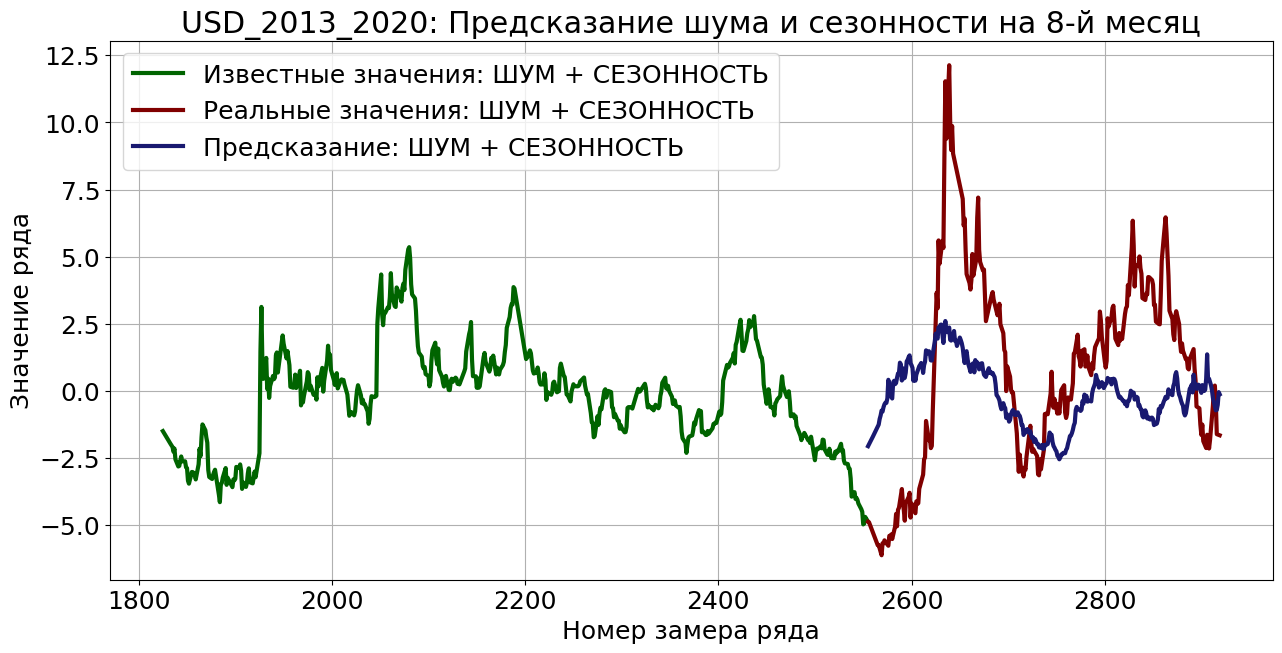

In [16]:
time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)
pred = pred_noise[0:PER_SIZE] + stl_decomp.seasonal[0:PER_SIZE]
true = stl_decomp.resid[time_pred] + stl_decomp.seasonal[time_pred]
past = stl_decomp.resid[time_past] + stl_decomp.seasonal[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения: ШУМ + СЕЗОННОСТЬ',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения: ШУМ + СЕЗОННОСТЬ',
    time3 = time_pred,
    data3 = pred,
    label3 = 'Предсказание: ШУМ + СЕЗОННОСТЬ',
    title = (
        data_name + ': Предсказание шума и сезонности на ' +
        str(TRAIN_PER + 1) + '-й месяц'
        ),
    x_label = 'Номер замера ряда',
    count = 3
    )

## 2.5 Прогноз ряда

### 2.5.1 Прогноз с линейным трендом

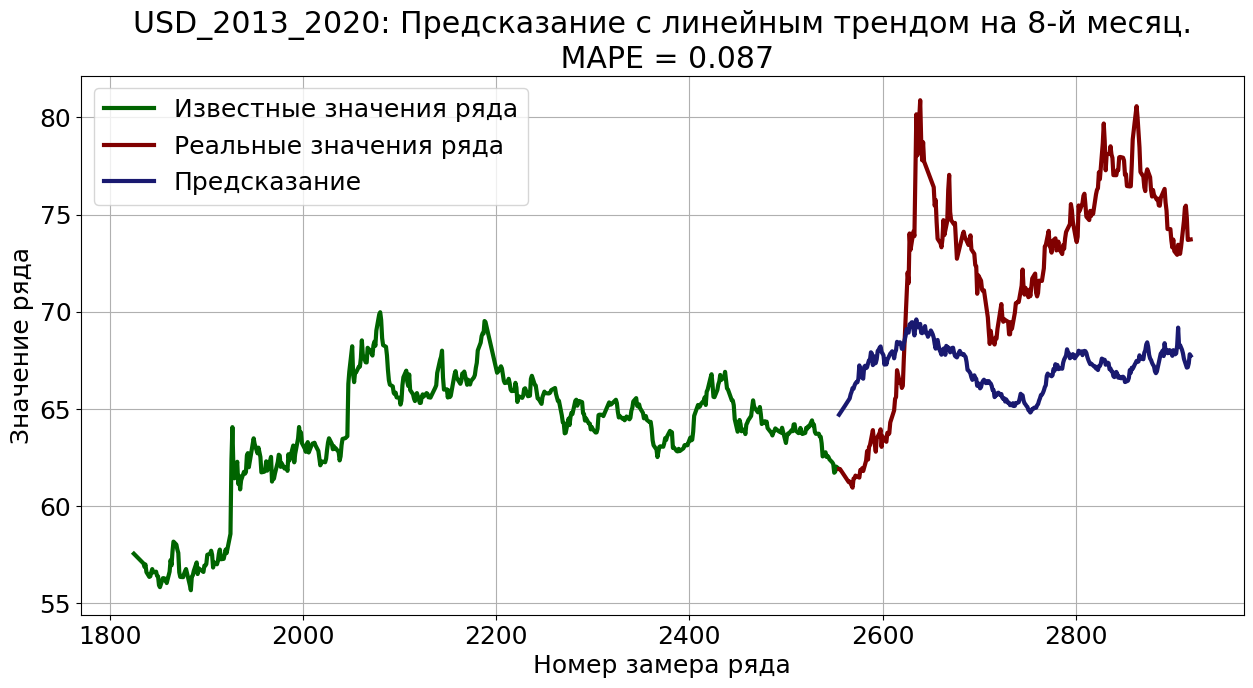

In [17]:
time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)
pred_lin = pred_noise[0:PER_SIZE] + stl_decomp.seasonal[0:PER_SIZE] + trend_frcst
#pred_lin = pred_noise[0:PER_SIZE] + trend_frcst
true = series[time_pred]
past = series[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения ряда',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения ряда',
    time3 = time_pred,
    data3 = pred_lin,
    label3 = 'Предсказание',
    title = (
        data_name + ': Предсказание с линейным трендом на ' +
        str(TRAIN_PER + 1) + '-й месяц.\n MAPE = ' +
        str(float('{:.3f}'.format(mape(true[-PER_SIZE:].values,pred_lin))))
        ),
    x_label = 'Номер замера ряда',
    count = 3
    )

### 2.5.2 Прогноз с трендом EWMA

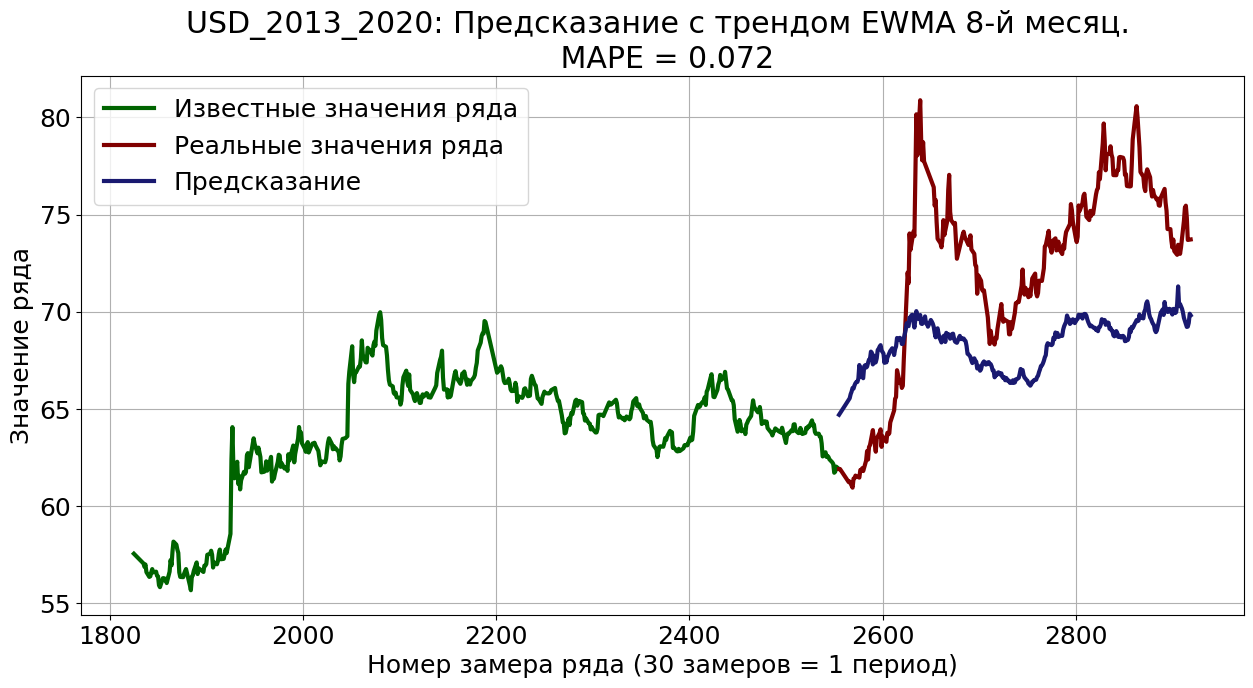

In [18]:
time_pred = np.arange(TRAIN_PER * PER_SIZE,(TRAIN_PER + 1) * PER_SIZE)
time_past = np.arange((TRAIN_PER - 2) * PER_SIZE, TRAIN_PER * PER_SIZE)
pred_ewma = pred_noise[0:PER_SIZE] + stl_decomp.seasonal[0:PER_SIZE] + ewma_forecast
#pred_ewma = pred_noise[0:PER_SIZE] + ewma_forecast
true = series[time_pred]
past = series[time_past]

plot_data(
    time1 = time_past,
    data1 = past,
    label1 = 'Известные значения ряда',
    time2 = time_pred,
    data2 = true,
    label2 = 'Реальные значения ряда',
    time3 = time_pred,
    data3 = pred_ewma,
    label3 = 'Предсказание',
    title = (
        data_name + ': Предсказание с трендом EWMA ' +
        str(TRAIN_PER + 1) + '-й месяц. \n MAPE = ' +
        str(float('{:.3f}'.format(mape(true[-PER_SIZE:].values,pred_ewma))))
        ),
    x_label = 'Номер замера ряда (30 замеров = 1 период)',
    count = 3
    )

# 3. Прогноз с помощью библиотеки prophet

Строим прогноз на PER_SIZE дней с помощью пакета prophet

In [19]:
PER_SIZE = 365
TRAIN_PER = 7

data = full_data.copy()
data.rename(
    columns = {data.columns[0]: 'ds', data.columns[1]: 'y'},
    inplace = True
    )

m = Prophet()
train_df = data[0: PER_SIZE * TRAIN_PER] 
m.fit(train_df)
pred_date = m.make_future_dataframe(periods = PER_SIZE)
pred = m.predict(pred_date)
pred_prophet = pred.tail(PER_SIZE).yhat.values

21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing


Строим прогноз с помощью пакета prophet, добавив два регрессора, которые в прошлом равны сглаженному гармониками ряду, а в будущем - прогнозам, построенным в пункте 2.

In [20]:
COUNT_GARM = TRAIN_PER * 2

[koef_lin_a, koef_lin_b] = coeff_lin(data.index, data.y)
trend = koef_lin_a * data.index + koef_lin_b

summ = np.zeros(time_range)
series = data.y - trend
phase =  2 * mt.pi * np.arange(time_range) / time_range
for i in range(COUNT_GARM):
  koef = AFO_Fourier(series, i + 1)
  garm = koef[1] * np.cos((i + 1) * phase) + koef[2] * np.sin((i + 1) * phase)
  summ += garm
summ += koef[0]

data_reg = data.copy()
data_reg['regressor1'] = summ + trend
data_reg['regressor2'] = summ + trend
data_reg.regressor1[PER_SIZE * TRAIN_PER : PER_SIZE * (TRAIN_PER + 1)] = pred_lin
data_reg.regressor2[PER_SIZE * TRAIN_PER : PER_SIZE * (TRAIN_PER + 1)] = pred_ewma

m_reg = Prophet()
m_reg.add_regressor('regressor1')
m_reg.add_regressor('regressor2')
train_df_reg = data_reg[0: PER_SIZE * TRAIN_PER] 
m_reg.fit(train_df_reg)
pred_date = m_reg.make_future_dataframe(periods = PER_SIZE)
pred_date['regressor1'] = data_reg.regressor1[0 : PER_SIZE * (TRAIN_PER + 1)]
pred_date['regressor2'] = data_reg.regressor2[0 : PER_SIZE * (TRAIN_PER + 1)]
pred = m_reg.predict(pred_date)
pred_prophet_reg = pred.tail(PER_SIZE).yhat.values

21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing


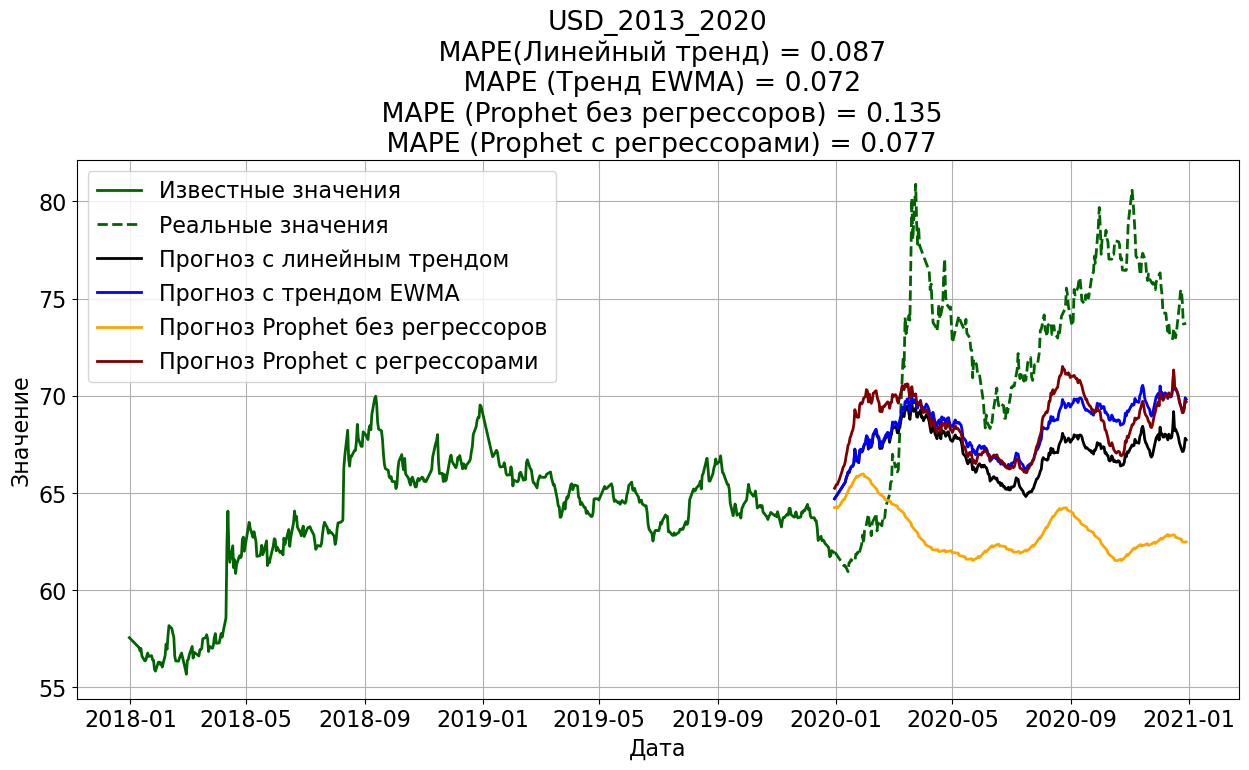

In [21]:
MAPE_lin = float('{:.3f}'.format(mape(true[-PER_SIZE:].values, pred_lin)))
MAPE_ewma = float('{:.3f}'.format(mape(true[-PER_SIZE:].values, pred_ewma)))
MAPE_prophet = float('{:.3f}'.format(mape(true[-PER_SIZE:].values, pred_prophet)))
MAPE_prophet_reg = float('{:.3f}'.format(mape(true[-PER_SIZE:].values, pred_prophet_reg)))

time_past = data.ds[time_past]
time_pred = data.ds[time_pred]

plot_data_pred(
    time_past = time_past,
    time_pred = time_pred,
    past = past,
    true = true,
    pred1 = pred_lin,
    pred2 = pred_ewma,
    pred3 = pred_prophet,
    pred4 = pred_prophet_reg,
    label1 = 'Прогноз с линейным трендом',
    label2 = 'Прогноз с трендом EWMA',
    label3 = 'Прогноз Prophet без регрессоров',
    label4 = 'Прогноз Prophet с регрессорами',
    title = (
    data_name +
    '\n MAPE(Линейный тренд) = ' + str(MAPE_lin) +
    '\n MAPE (Тренд EWMA) = ' + str(MAPE_ewma) +
    '\n MAPE (Prophet без регрессоров) = ' + str(MAPE_prophet) +
    '\n MAPE (Prophet с регрессорами) = ' + str(MAPE_prophet_reg)
    )
    )